# Movement variability

This measures how accurately participants follow a straight line from the start to end positions in each trial.

Measure is from the following source:

> I. Scott MacKenzie, Tatu Kauppinen, and Miika Silfverberg. 2001. Accuracy measures for evaluating computer pointing devices. In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (CHI '01). Association for Computing Machinery, New York, NY, USA, 9–16. https://doi.org/10.1145/365024.365028

Definition of the **task axis**: the axis/line going from the start point of a drag to the end point. It refers to the target location, not the location actually touched.

**Movement Variability (MV)** is the extent to which points lie in a straight line parallel to the task axis. *In the spreadsheet, all measures have cm units. However, we report the units in mm, so we multiply everything by 10.*

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import rpy2
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
pen_touch_palette = sns.color_palette("colorblind", 5)
sns.set_palette(pen_touch_palette)
curvature_palette = sns.color_palette("colorblind", 6)[2:]
distance_palette = sns.color_palette("Paired")
x1fold_palette = sns.color_palette("Paired")[2:]
sns.set_style("whitegrid")
plt.rc('figure', figsize=(6.0, 4.0))
a_cols = sns.color_palette("flare", 4)
a_cols_rev = a_cols[1:-1]
a_cols_rev.reverse()
angle_palette = a_cols + a_cols_rev + a_cols + a_cols_rev

In [3]:
df_orig = pd.read_csv("../data/trials.csv")
df_orig

,participant,condition,condition_idx,prototype_idx,prototype_idx_nox1,prototype,curvature,input_type,block,task,...,trajectory_distance,time,n_attempts,task_axis_crossing,movement_direction_change,orthogonal_direction_change,movement_variability,movement_variability_hinge,movement_error,movement_offset
0,9,flat-touch,0,0,0,flat,0.0,touch,0,20,...,11.272381,1066.0,1,0,14,0,0.069686,0.069686,0.252669,0.252669
1,9,flat-touch,0,0,0,flat,0.0,touch,0,16,...,12.666076,1209.8,1,3,18,0,0.124161,0.069032,0.109941,0.106026
2,9,flat-touch,0,0,0,flat,0.0,touch,0,6,...,23.120409,1774.6,1,2,27,0,0.135713,0.088903,0.209538,0.203483
3,9,flat-touch,0,0,0,flat,0.0,touch,0,7,...,23.565728,1652.5,1,4,24,0,0.181455,0.130140,0.165829,0.065082
4,9,flat-touch,0,0,0,flat,0.0,touch,0,17,...,12.168719,1490.8,1,4,11,1,0.092684,0.054010,0.085471,-0.031356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10435,14,1mm-touch,11,5,4,1mm,1.0,touch,2,15,...,13.250031,1025.7,1,1,6,0,0.426786,0.224186,0.442196,-0.255015
10436,14,1mm-touch,11,5,4,1mm,1.0,touch,2,5,...,23.187428,1423.4,1,2,16,0,0.330995,0.031884,0.296933,-0.036865
10437,14,1mm-touch,11,5,4,1mm,1.0,touch,2,19,...,13.034942,1047.5,1,4,8,0,0.239853,0.273617,0.274385,0.255065
10438,14,1mm-touch,11,5,4,1mm,1.0,touch,2,23,...,12.726480,1177.0,1,4,8,0,0.110279,0.151618,0.101211,-0.044265


Convert units from cm to mm and remove flat surface used for practice

In [4]:
# Exclude the conditions on a flat surface used for practice only
df = pd.DataFrame(df_orig[df_orig["prototype_idx"] > 0])
df["movement_variability"] *= 10
df["movement_variability_hinge"] *= 10
print(len(df))

9720


## Testing for normality

In [5]:
%%R -i df

suppressPackageStartupMessages(library(car)) # leveneTest for homoscedasticity
suppressPackageStartupMessages(library(afex)) # for aov_car so we can do tukey tests
suppressPackageStartupMessages(library(emmeans)) # for emmeans pairwise contrasts (Tukey)
options(width=150) # make it easier to see huge matrices

df$participant <- factor(df$participant)
df$condition_idx <- factor(df$condition_idx)
df$prototype_idx <- factor(df$prototype_idx)
df$prototype <- factor(df$prototype)
df$curvature <- factor(df$curvature)
df$input_type <- factor(df$input_type)
df$is_long <- factor(df$is_long)
df$angle <- factor(df$angle)

### Normality test

In [6]:
%%R
m <- aov(movement_variability ~ prototype
        + Error(participant / prototype), data=df)
res <- residuals(m$`participant:prototype`)
shapiro.test(res)


	Shapiro-Wilk normality test

data:  res
W = 0.98796, p-value = 0.8196



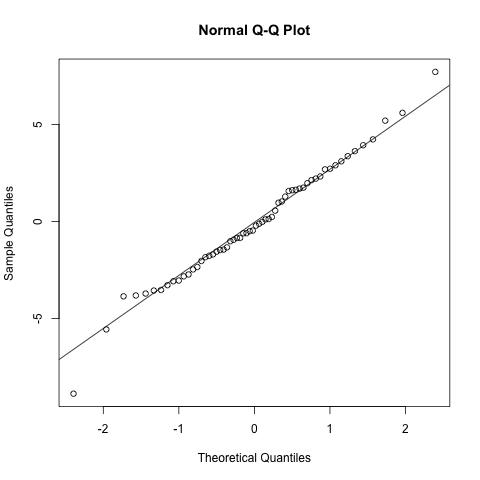

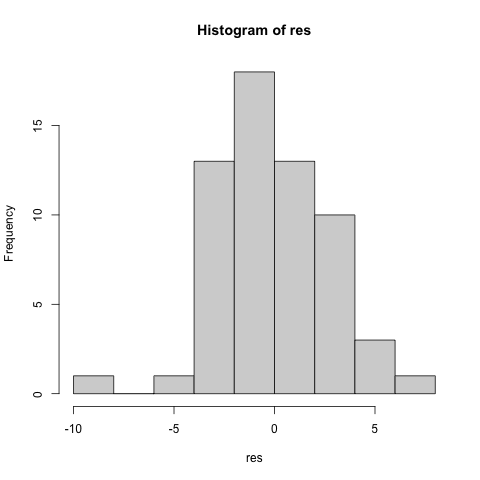

In [7]:
%%R
qqnorm(res)
qqline(res)
hist(res)

## Hinge Radius and Input Method

### Sphericity (fails)

In [8]:
%%R

df.nox1 <- subset(df, prototype != "x1fold")
df.nox1$prototype <- factor(df.nox1$prototype)

m.input <- aov_car(movement_variability ~ prototype * input_type + Error(participant / (prototype * input_type)), df.nox1)
summary(m.input)$sphericity

                     Test statistic p-value
prototype                   0.71001 0.50046
prototype:input_type        0.34477 0.01914


### ANOVA

In [9]:
%%R
# No GG correction
nice(m.input, es= "pes")

Anova Table (Type 3 tests)

Response: movement_variability
                Effect          df  MSE    F  pes p.value
1            prototype 2.39, 33.51 0.18 1.92 .121    .155
2           input_type       1, 14 0.12 0.47 .033    .502
3 prototype:input_type 1.75, 24.43 0.15 1.24 .081    .302
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


## Touch

Because pen and touch are very different input methods, we analyse them separately.

### Sphericity (fails)

In [10]:
%%R
df.touch <- subset(df.nox1, input_type == "touch")
m.touch <- aov_car(movement_variability ~ prototype * is_long * angle + Error(participant / (prototype * is_long * angle)), df.touch)
summary(m.touch)$sphericity

                  Test statistic p-value
prototype                0.74513 0.59022
angle                    0.00013 0.04675
prototype:is_long        0.85618 0.85386
is_long:angle            0.00155 0.62332


### ANOVA

In [11]:
%%R
nice(m.touch, es = "pes")
# m.touch

Anova Table (Type 3 tests)

Response: movement_variability
                   Effect          df  MSE         F  pes p.value
1               prototype 2.59, 36.27 1.85    3.28 * .190    .038
2                 is_long       1, 14 1.31 70.98 *** .835   <.001
3                   angle 4.67, 65.42 2.65 13.81 *** .497   <.001
4       prototype:is_long 2.72, 38.13 0.68      1.14 .075    .344
5         prototype:angle     33, 462 0.65    1.52 * .098    .034
6           is_long:angle 5.80, 81.24 1.19      0.24 .017    .960
7 prototype:is_long:angle     33, 462 0.43      1.31 .085    .123
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


### Hinge Radius

In [12]:
%%R
p.touch.curv <- emmeans(m.touch, "prototype")
pwpm(p.touch.curv)

        X12mm    X1mm   X24mm   X6mm
X12mm  [2.43]  0.0725  0.9134 0.6727
X1mm  -0.2790  [2.71]  0.0367 0.4616
X24mm -0.0559  0.2231  [2.48] 0.9170
X6mm  -0.1128  0.1662 -0.0568 [2.54]

Row and column labels: prototype
Upper triangle: P values   adjust = “tukey”
Diagonal: [Estimates] (emmean) 
Lower triangle: Comparisons (estimate)   earlier vs. later


In [13]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.groupby("prototype").mean()["movement_variability"]

prototype
12mm    2.426200
1mm     2.705198
24mm    2.482135
6mm     2.538960
Name: movement_variability, dtype: float64

### Angle

- 0 is diff from 30, 150, 210, 330
- 0/90/180/270 diff from others
- 30/150/210/330 were worst

In [14]:
%%R
p.touch.angle <- emmeans(m.touch, "angle")
pwpm(p.touch.angle)

          X0     X30     X60     X90    X120    X150    X180    X210    X240    X270    X300   X330
X0    [2.06]  0.0037  0.0849  0.9416  0.5087  0.0008  0.8610  <.0001  0.0646  1.0000  0.5916 0.0073
X30  -0.9851  [3.04]  0.2766  0.0044  0.0072  1.0000  0.0378  0.9911  0.0734  0.0002  0.0022 0.9923
X60  -0.6148  0.3703  [2.67]  0.0622  0.5626  0.3720  0.4403  0.9248  0.9364  0.0695  0.5812 0.8138
X90  -0.1828  0.8023  0.4321  [2.24]  0.9499  0.0006  1.0000  0.0009  0.6490  0.9993  0.9929 0.0631
X120 -0.3501  0.6350  0.2647 -0.1674  [2.41]  0.0003  0.9482  0.0420  0.9989  0.5804  1.0000 0.0584
X150 -0.9720  0.0131 -0.3572 -0.7892 -0.6219  [3.03]  0.0106  0.9799  0.0576  0.0004  0.0004 0.9989
X180 -0.1351  0.8500  0.4797  0.0477  0.2150  0.8369  [2.19]  0.0024  0.4566  1.0000  0.9534 0.0420
X210 -0.8244  0.1607 -0.2096 -0.6416 -0.4743  0.1476 -0.6893  [2.88]  0.1127  <.0001  0.0584 1.0000
X240 -0.4410  0.5441  0.1739 -0.2582 -0.0908  0.5310 -0.3059  0.3834  [2.50]  0.1060  0.9967 0.2013


In [15]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("angle").mean()["movement_variability"]

angle
0.0      2.055414
30.0     3.040517
60.0     2.670228
90.0     2.238167
120.0    2.405539
150.0    3.027394
180.0    2.190499
210.0    2.879806
240.0    2.496371
270.0    2.136398
300.0    2.391066
330.0    2.926080
Name: movement_variability, dtype: float64

### MV by Angle for Touch

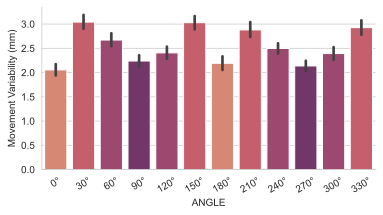

In [16]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df = curr_df.rename({"movement_variability": "Movement Variability (mm)"}, axis=1)
curr_df["ANGLE"] = curr_df["angle"].apply(lambda x: f"{int(x)}°")
plt.figure(figsize=(6.0, 3.0))
ax = sns.barplot(
    data=curr_df,
    x="ANGLE",
    y="Movement Variability (mm)",
    order=["0°", "30°", "60°", "90°", "120°", "150°", "180°", "210°", "240°", "270°", "300°", "330°"],
    ci=95,
    n_boot=10000,
    palette=angle_palette,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
sns.despine(ax=ax)
plt.savefig(f"exp1-mv-touch-angle.pdf")
plt.show()

### Interaction: Hinge Radius by Angle

- 1mm: trend as before
- 6mm: 0 and 180 have no sig diffs, 90 and 270 = 150, 210
- 12mm: not 210, 330 for any of them
- 24mm: no sig diffs

In [17]:
%%R
p.touch.curv.angle <- emmeans(m.touch, c("prototype", "angle"))
pwpm(p.touch.curv.angle, "prototype")


prototype = X12mm
          X0     X30     X60     X90    X120    X150    X180    X210    X240    X270    X300   X330
X0    [1.90]  0.0221  0.0373  0.5703  0.3151  0.0041  1.0000  0.0764  0.3626  1.0000  0.2492 0.0970
X30  -1.0463  [2.94]  0.5864  0.0718  0.1629  1.0000  0.0285  0.9430  0.2327  0.0120  0.4828 0.9997
X60  -0.6525  0.3938  [2.55]  0.7503  0.9369  0.6354  0.1264  0.9998  0.9905  0.2183  1.0000 0.9537
X90  -0.3887  0.6576  0.2639  [2.29]  1.0000  0.0263  0.7372  0.3871  1.0000  0.8612  0.9902 0.7320
X120 -0.4326  0.6137  0.2200 -0.0439  [2.33]  0.1650  0.4052  0.8256  1.0000  0.7301  0.9945 0.6536
X150 -0.9890  0.0573 -0.3365 -0.6004 -0.5565  [2.89]  0.0127  0.9938  0.3552  0.0360  0.8627 1.0000
X180  0.0578  1.1040  0.7103  0.4464  0.4903  1.0468  [1.84]  0.0939  0.2586  0.9990  0.1835 0.1333
X210 -0.8044  0.2419 -0.1519 -0.4157 -0.3718  0.1846 -0.8622  [2.70]  0.7711  0.0602  0.9988 1.0000
X240 -0.4756  0.5707  0.1770 -0.0869 -0.0430  0.5135 -0.5333  0.3288  [2.37]  0.1

In [18]:
curr_df = pd.DataFrame(df[
    (df["prototype"] == "24mm")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("angle").mean()["movement_variability"]

angle
0.0      2.045789
30.0     2.761407
60.0     2.402409
90.0     2.337227
120.0    2.387939
150.0    2.986855
180.0    2.106774
210.0    2.670175
240.0    2.687474
270.0    2.299779
300.0    2.174564
330.0    2.925231
Name: movement_variability, dtype: float64

### Touch MV for long/short

In [19]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "touch")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("is_long").mean()["movement_variability"]

is_long
False    2.283969
True     2.792278
Name: movement_variability, dtype: float64

## Pen

### Sphericity (fails)

In [20]:
%%R
df.pen <- subset(df.nox1, input_type == "pen")
m.pen <- aov_car(movement_variability ~ prototype * is_long * angle + Error(participant / (prototype * is_long * angle)), df.pen)
summary(m.pen)$sphericity

                  Test statistic  p-value
prototype                0.38019 0.032431
angle                    0.00019 0.076512
prototype:is_long        0.28614 0.007663
is_long:angle            0.00021 0.090833


### ANOVA

In [21]:
%%R
# use GG correction
nice(m.pen, es = "pes")

Anova Table (Type 3 tests)

Response: movement_variability
                   Effect          df  MSE         F  pes p.value
1               prototype 1.80, 25.18 6.58      1.02 .068    .368
2                 is_long       1, 14 0.80 85.39 *** .859   <.001
3                   angle 5.02, 70.26 4.26  8.66 *** .382   <.001
4       prototype:is_long 1.74, 24.42 1.63      0.87 .059    .416
5         prototype:angle     33, 462 1.25      1.12 .074    .304
6           is_long:angle 5.32, 74.53 1.41      1.51 .097    .193
7 prototype:is_long:angle     33, 462 0.83    1.42 + .092    .063
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘+’ 0.1 ‘ ’ 1

Sphericity correction method: GG 


### Angle

Note how:
- Both 0 and 180 only have significant differences with 270
- 90 and 270 both have less MV than acutely angled drags.

In [22]:
%%R
p.pen <- emmeans(m.pen, "angle")
pwpm(p.pen)

           X0      X30      X60      X90     X120     X150     X180     X210     X240     X270     X300   X330
X0     [2.62]   0.9668   0.8354   0.4293   0.9957   0.3590   0.2720   0.9097   0.9902   0.0378   0.9948 1.0000
X30  -0.27090   [2.89]   0.1849   0.0370   0.5633   0.9262   1.0000   1.0000   0.2878   0.0210   0.3177 0.9591
X60   0.29150  0.56240   [2.33]   0.7888   0.9775   0.0114   0.2255   0.0310   0.9986   0.3560   0.9983 0.3103
X90   0.50685  0.77776  0.21535   [2.11]   0.2200   0.0026   0.1344   0.0503   0.5415   0.9993   0.1244 0.1546
X120  0.16308  0.43398 -0.12842 -0.34378   [2.46]   0.0112   0.3786   0.3274   1.0000   0.1364   1.0000 0.9463
X150 -0.67676 -0.40586 -0.96826 -1.18362 -0.83984   [3.30]   0.9139   0.8812   0.0179   0.0075   0.0255 0.0866
X180 -0.29146 -0.02056 -0.58296 -0.79832 -0.45454  0.38530   [2.91]   1.0000   0.5556   0.0047   0.5525 0.7692
X210 -0.28676 -0.01585 -0.57825 -0.79361 -0.44983  0.39001  0.00471   [2.91]   0.1781   0.0020   0.3364 0.9177
X

In [23]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("angle").mean()["movement_variability"]

angle
0.0      2.619523
30.0     2.890427
60.0     2.328024
90.0     2.112671
120.0    2.456448
150.0    3.296287
180.0    2.910986
210.0    2.906278
240.0    2.408831
270.0    1.980620
300.0    2.423072
330.0    2.648254
Name: movement_variability, dtype: float64

### MV by Angle for Pen

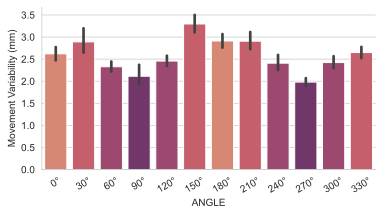

In [24]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
fig = plt.figure(figsize=(6.0, 3.0))
curr_df = curr_df.rename({"movement_variability": "Movement Variability (mm)"}, axis=1)
curr_df["ANGLE"] = curr_df["angle"].apply(lambda x: f"{int(x)}°")
ax = sns.barplot(
    data=curr_df,
    x="ANGLE",
    y="Movement Variability (mm)",
    order=["0°", "30°", "60°", "90°", "120°", "150°", "180°", "210°", "240°", "270°", "300°", "330°"],
    ci=95,
    n_boot=10000,
    palette=angle_palette,
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
sns.despine(ax=ax)
plt.savefig(f"exp1-mv-pen-angle.pdf")
plt.show()

In [25]:
curr_df = pd.DataFrame(df[
    (df["prototype"] != "x1fold")
    & (df["input_type"] == "pen")
])
curr_df.reset_index(drop=True, inplace=True)
curr_df.groupby("is_long").mean()["movement_variability"]

is_long
False    2.363728
True     2.799842
Name: movement_variability, dtype: float64